In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instacart-market-basket-analysis/products.csv/products.csv
/kaggle/input/instacart-market-basket-analysis/sample_submission.csv/sample_submission.csv
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv/order_products__train.csv
/kaggle/input/instacart-market-basket-analysis/orders.csv/orders.csv
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv/order_products__prior.csv
/kaggle/input/instacart-market-basket-analysis/aisles.csv/aisles.csv
/kaggle/input/instacart-market-basket-analysis/departments.csv/departments.csv


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

instacart-market-basket-analysis



In [5]:
order_products_train_df = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/order_products__train.csv/order_products__train.csv")
order_products_prior_df = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv/order_products__prior.csv")
orders_df = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/orders.csv/orders.csv")
products_df = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/products.csv/products.csv")
aisles_df = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/aisles.csv/aisles.csv")
departments_df = pd.read_csv("/kaggle/input/instacart-market-basket-analysis/departments.csv/departments.csv")

In [50]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [51]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [52]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


##### 총 206,209명의 고객이 있다. 그중 지난 131,209명의 고객이 train set으로 주어진 것이고 우리는 이제 나머지 75,000명의 고객을 예측할 필요가 있다. 

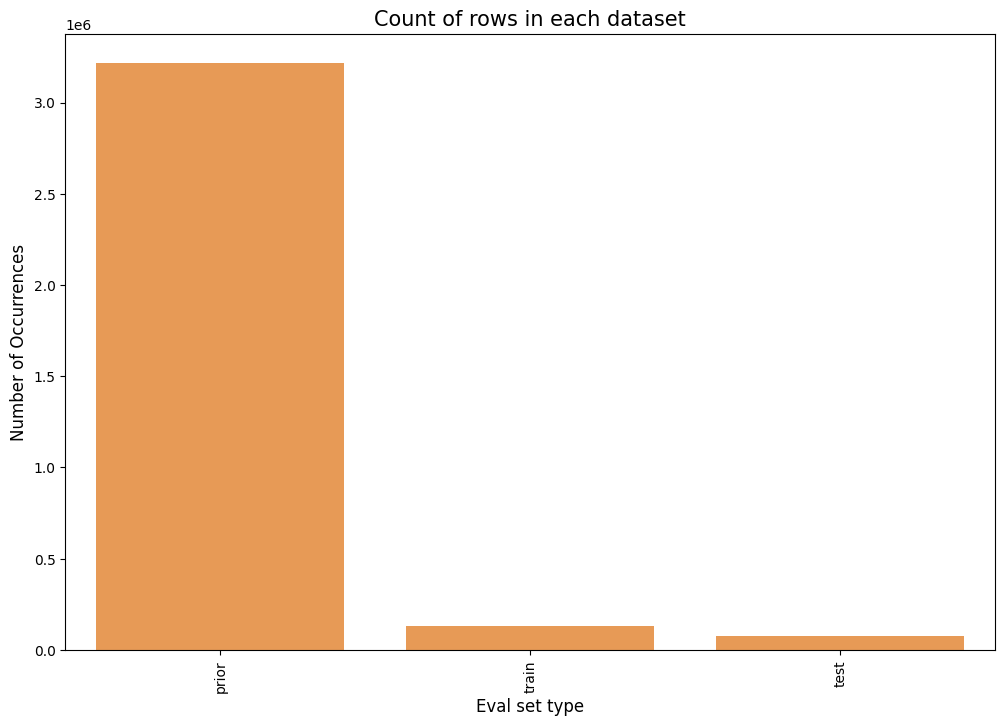

In [53]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

 ##### np.unique()는 주어진 배열에서 중복된 값을 제거하고 고유한 값을 정렬된 형태로 반환하는 함수이다. 

In [54]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

#### 🚩그렇다면 4개에서 100개 사이의 고객의 주문이 들어왔다는 것을 검증해보자!

/tmp/ipykernel_1783/558827441.py:1: FutureWarning: The provided callable <function max at 0x7a877411c3a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()


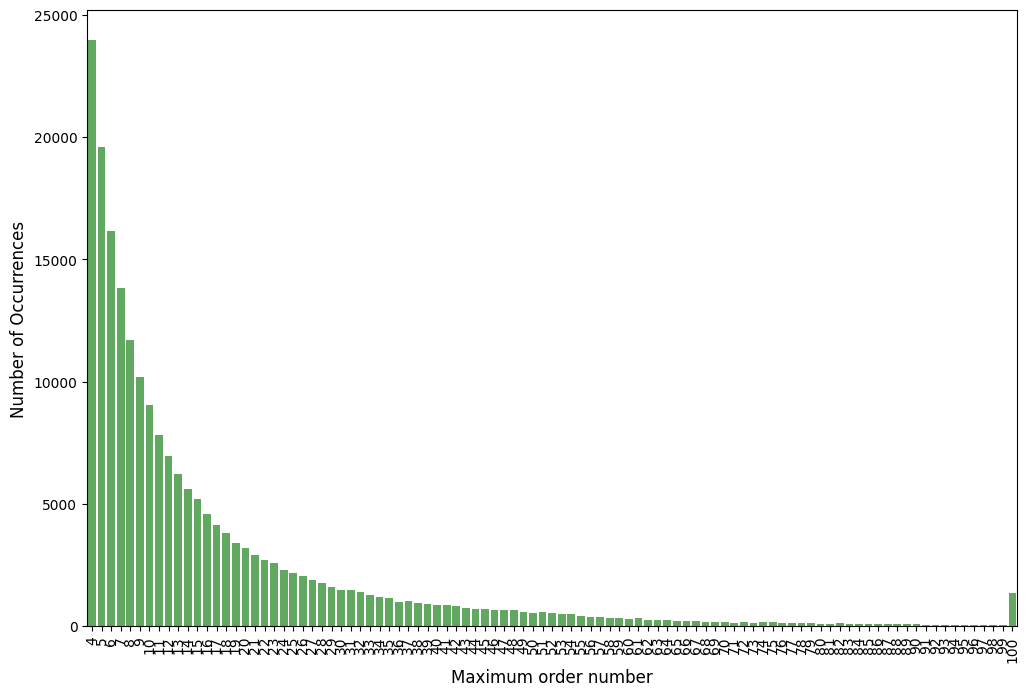

In [55]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

##### 그래서 주문 수가 4개 미만인 경우는 없고, 최대 주문 수는 데이터 페이지에 명시된 대로 100개로 제한되어 있음을 알 수 있다. 

#### 🚩그럼 이제 요일에 따라 고객의 주문 패턴이나 습관이 어떻게 달라지는지 살펴보자! (여기서 order_dow는 "order day of week"의 약어로, 데이터에서 각 주문이 발생한 요일을 나타냄)

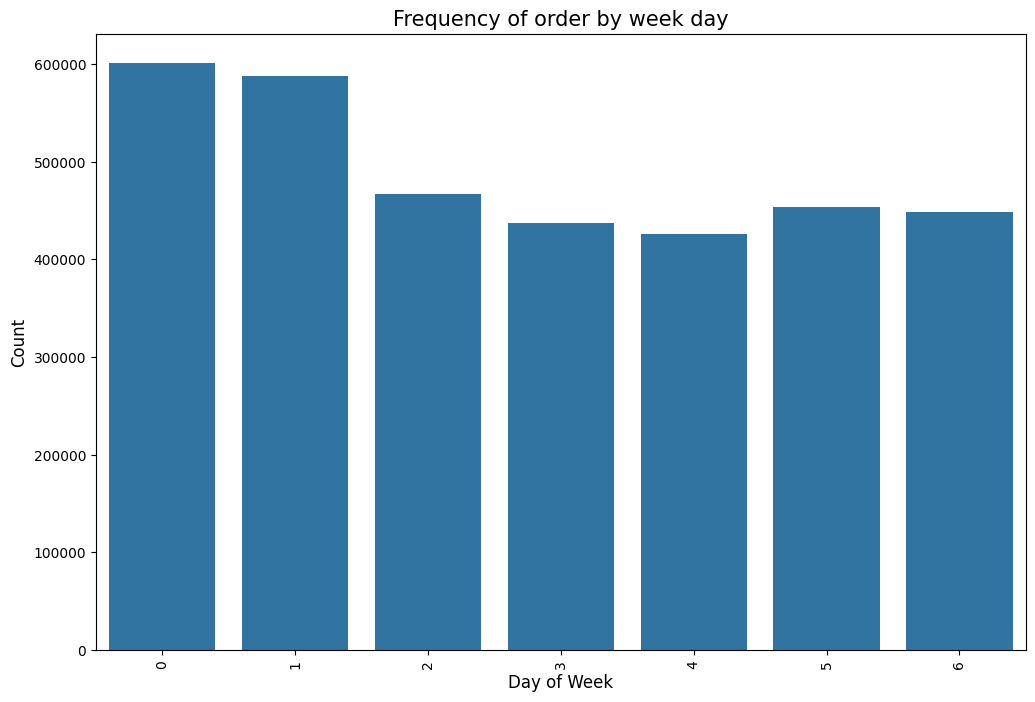

In [56]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of order by week day', fontsize=15)
plt.show()

##### 0과 1은 각각 토요일과 일요일로 보이며, 수요일에 주문이 가장 적은 것 같다.

#### 🚩그럼 이제 하루 중 시간에 따라 분포가 어떻게 되는지 살펴보자!

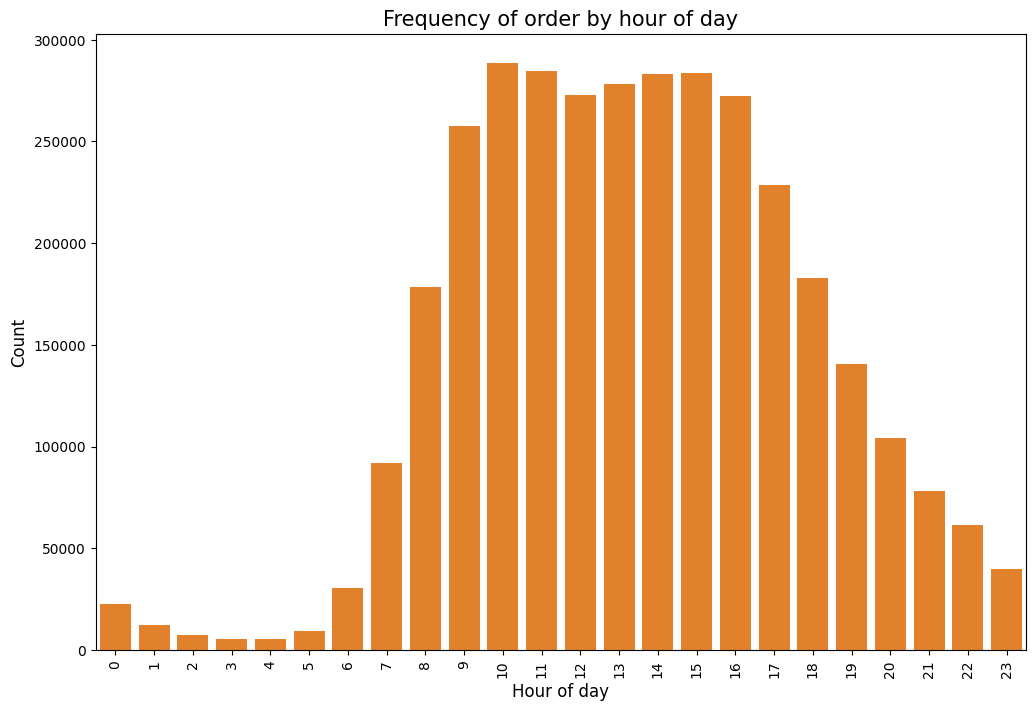

In [57]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of order by hour of day', fontsize=15)
plt.show()

##### 주문의 대부분이 낮 시간대에 이루어지는 것을 알 수 있다

#### 🚩그럼 요일과 시간대를 결합하여 분포를 살펴보자! 

##### 피벗 테이블(pivot table)은 특정 열의 값을 기준으로 다른 열의 데이터를 집계하여 요약하는 데 쓰이는 유용한 도구이다. 

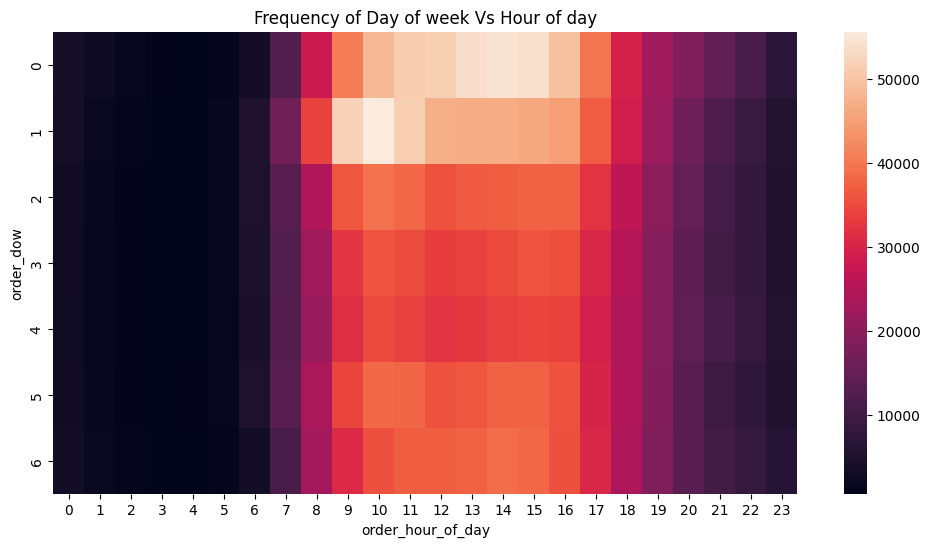

In [58]:
grouped_df = orders_df.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate('count').reset_index()
grouped_df = grouped_df.pivot(index= 'order_dow', columns= 'order_hour_of_day', values= 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title('Frequency of Day of week Vs Hour of day')
plt.show()

##### Satuday evenings and Sunday mornings이 가장 주문이 많은 시간대임을 알 수 있다. 

##### heatmap을 만든 피벗 테이블은 다음과 같다. 

In [59]:
grouped_df

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,3936,2398,1409,963,813,1168,3329,12410,28108,40798,...,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
1,3674,1830,1105,748,809,1607,5370,16571,34116,51908,...,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
2,3059,1572,943,719,744,1399,4758,13245,24635,36314,...,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
3,2952,1495,953,654,719,1355,4562,12396,22553,32312,...,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
4,2642,1512,899,686,730,1330,4401,12493,21814,31409,...,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645
5,3189,1672,1016,841,910,1574,4866,13434,24015,34232,...,37407,37508,35860,29955,24310,18741,13322,9515,7498,5265
6,3306,1919,1214,863,802,1136,3243,11319,22960,30839,...,38748,38093,35562,30398,24157,18346,13392,10501,8532,6087


#### 🚩그럼 이제 주문 간의 시간 간격을 확인해보자! 

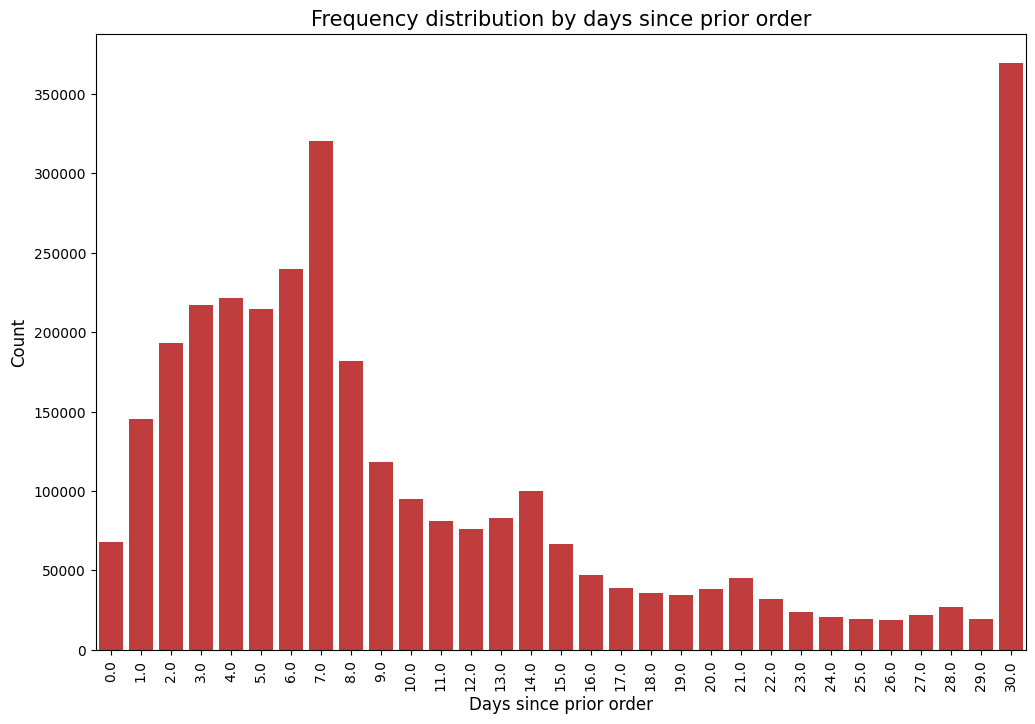

In [60]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency distribution by days since prior order', fontsize=15)
plt.show()

##### 고객들이 매주 한 번(7일에서의 피크) 또는 매월 한 번(30일에서의 피크) 주문하는 것으로 보인다. 또한 14일, 21일, 28일(주간 간격)에서도 작은 피크를 확인할 수 있다.

#### 🚩우리의 목표가 재주문을 파악하는 것이므로, prior set와 train set에서 재주문 비율을 확인하자!

In [61]:
# percentage of re-orders in prior set # 
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [62]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

##### 평균적으로, 주문 내의 제품 중 약 59%가 재주문된 제품이다

#### 🚩제품 중 재주문된 것이 전혀 없는 경우도 있을 것이다. 이제 그것을 확인해 보자!

In [63]:
grouped_df = order_products_prior_df.groupby('order_id')['reordered'].aggregate('sum').reset_index()
grouped_df.loc[grouped_df['reordered']>1,'reordered'] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

reordered
1    0.879151
0    0.120849
Name: count, dtype: float64

In [64]:
grouped_df = order_products_train_df.groupby('order_id')['reordered'].aggregate('sum').reset_index()
grouped_df.loc[grouped_df['reordered']>1,'reordered'] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

reordered
1    0.93444
0    0.06556
Name: count, dtype: float64

##### prior set에서는 약 주문의 12%가 재주문이 없었던 제품이라면, train set 에서는 주문의 6.5%가 재주문이 없었던 제품이다. 

#### 🚩각 주문에서 구매된 제품의 수를 확인해보자! 

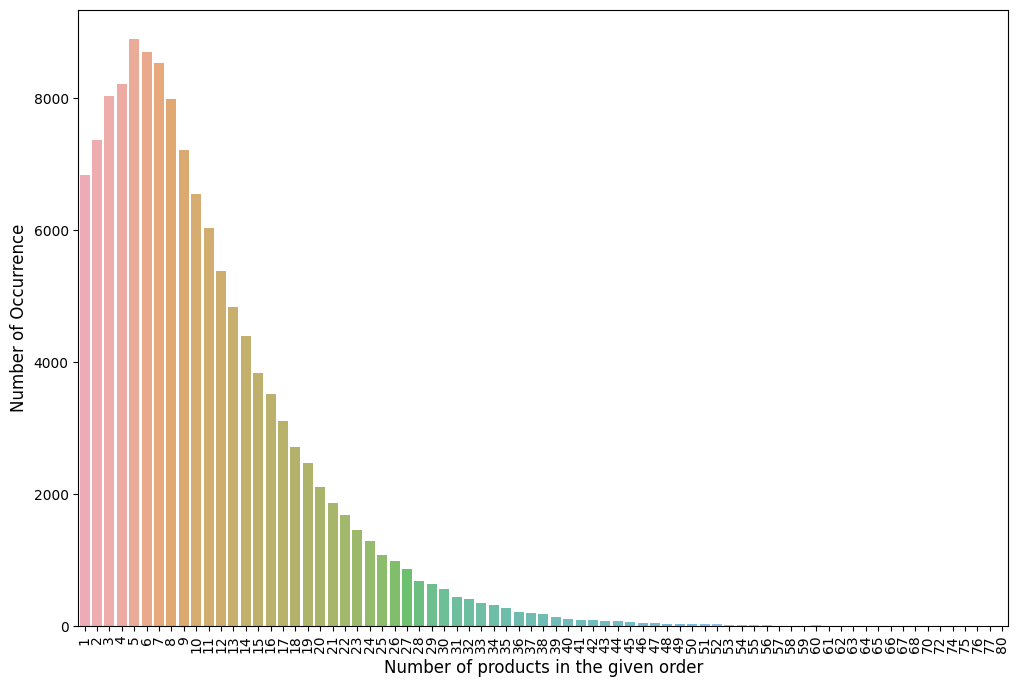

In [65]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate('max').reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrence', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

##### 5에서 최대값을 갖는 right tailed distribution 임을 알 수 있다.

#### 다른 3개의 파일도 살펴보자! 

In [66]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [67]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [68]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


#### 🚩이 제품 세부 사항을 order_prior와 병합해보자! 

In [69]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


##### order_products_prior_df와 products_df를 product_id라는 공통 열을 기준으로 병합한다. how='left'는 왼쪽 데이터프레임 (order_products_prior_df)의 모든 행을 유지하고, products_df에서 일치하는 행이 있으면 결합한다. 일치하지 않는 경우, 해당 값은 NaN으로 처리한다.

In [70]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


##### 대부분이 organic items인 것을 알 수 있다. 또한 그중에서도 과일이 대부분이다. 

#### 🚩그렇다면 중요한 aisle을 알아보자! 

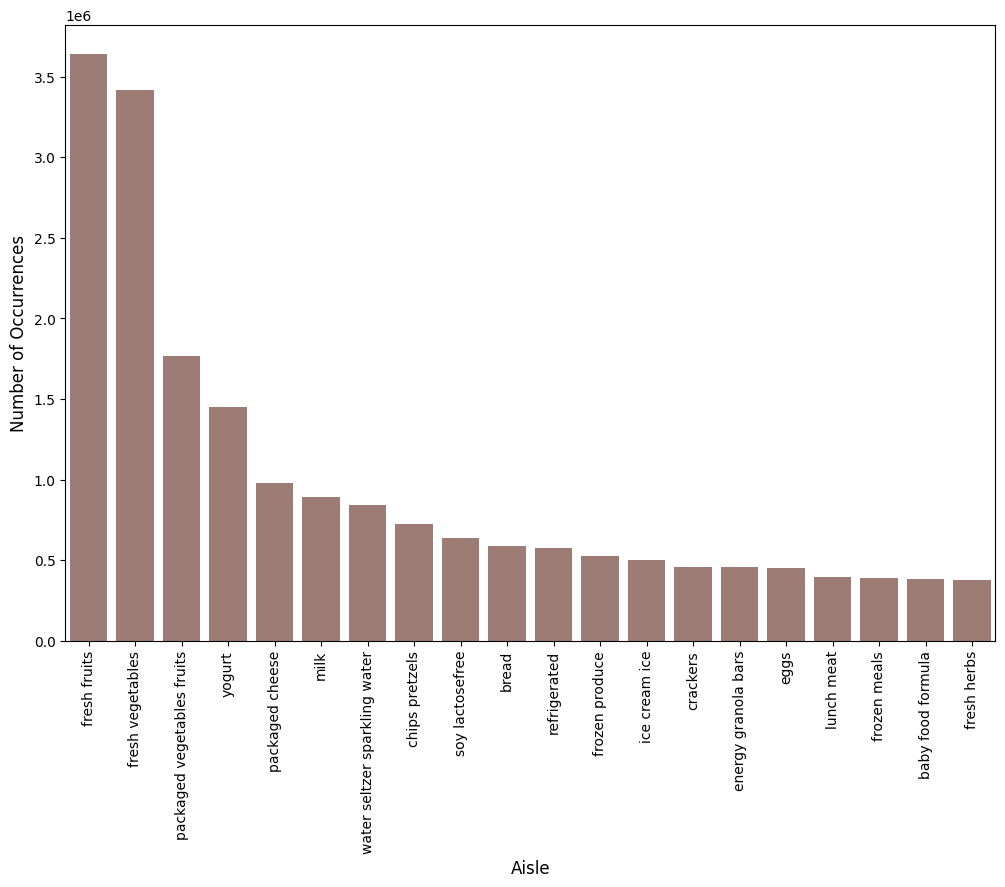

In [71]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

##### Top 2 aisle은 fresh fruit과 fresh vegetables 임을 알 수 있다. 

#### 🚩Department distribution

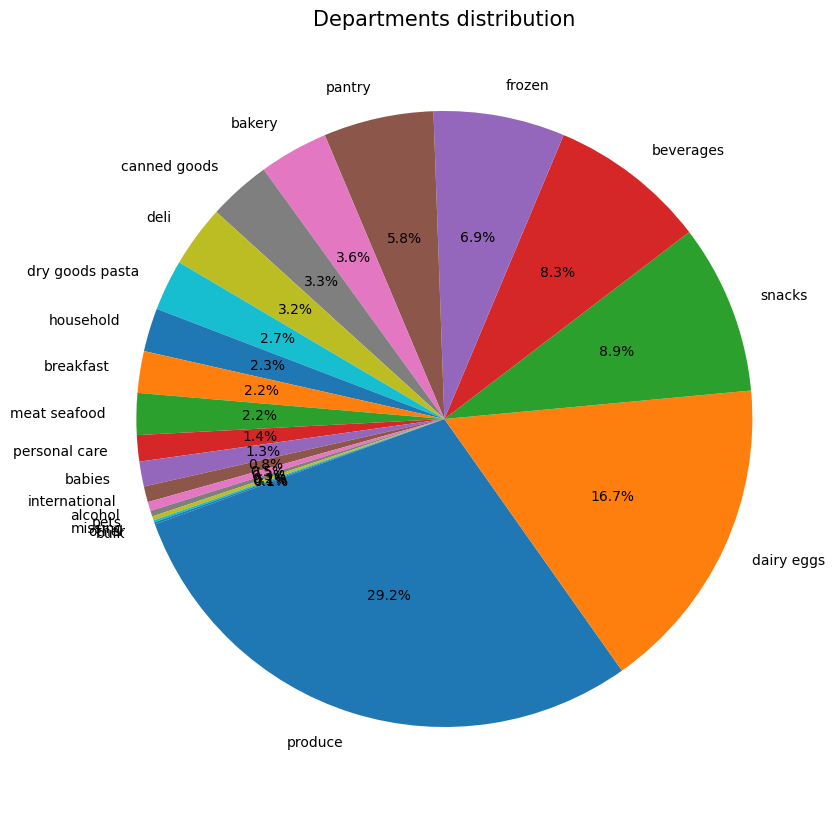

In [72]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels= (np.array(temp_series.index))
sizes= (np.array((temp_series/temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct = '%1.1f%%', startangle=200)
plt.title('Departments distribution', fontsize=15)
plt.show()

##### produce가 가장 큰 department임을 알 수 있다. 

#### 🚩Department wise reorder ratio

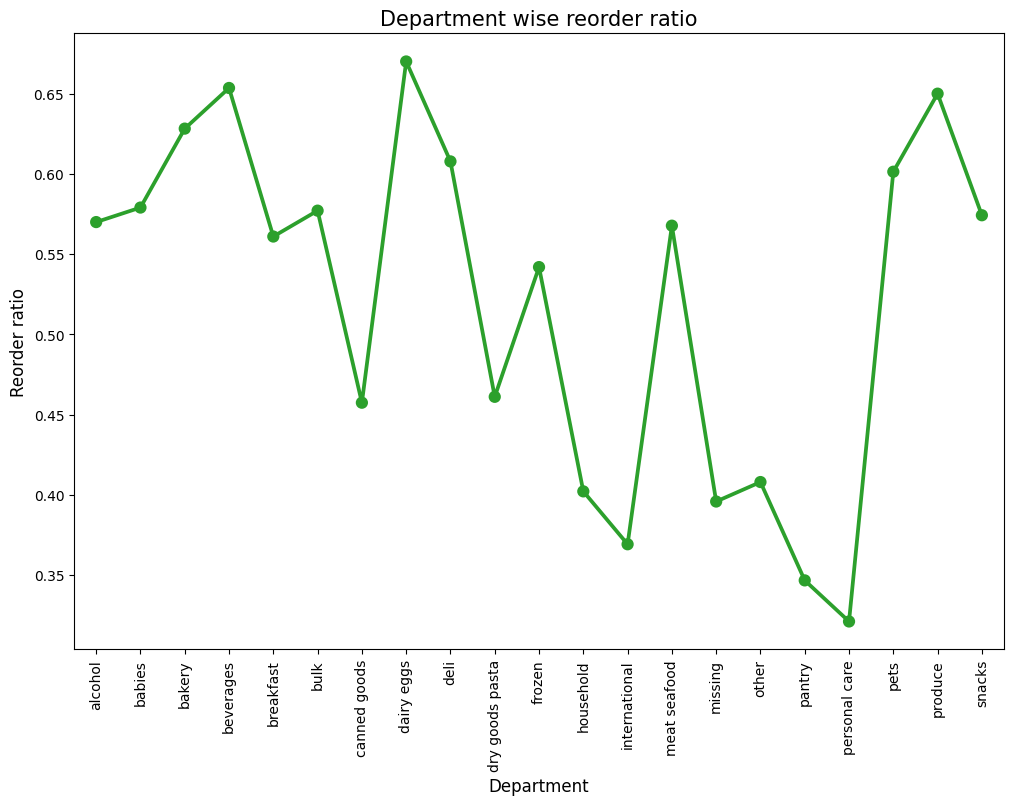

In [73]:
grouped_df = order_products_prior_df.groupby(['department'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['department'].values, y=grouped_df['reordered'].values, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title('Department wise reorder ratio', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

##### lowest: personal care / highest: dairy eggs

#### 🚩Aisle - Reorder ratio

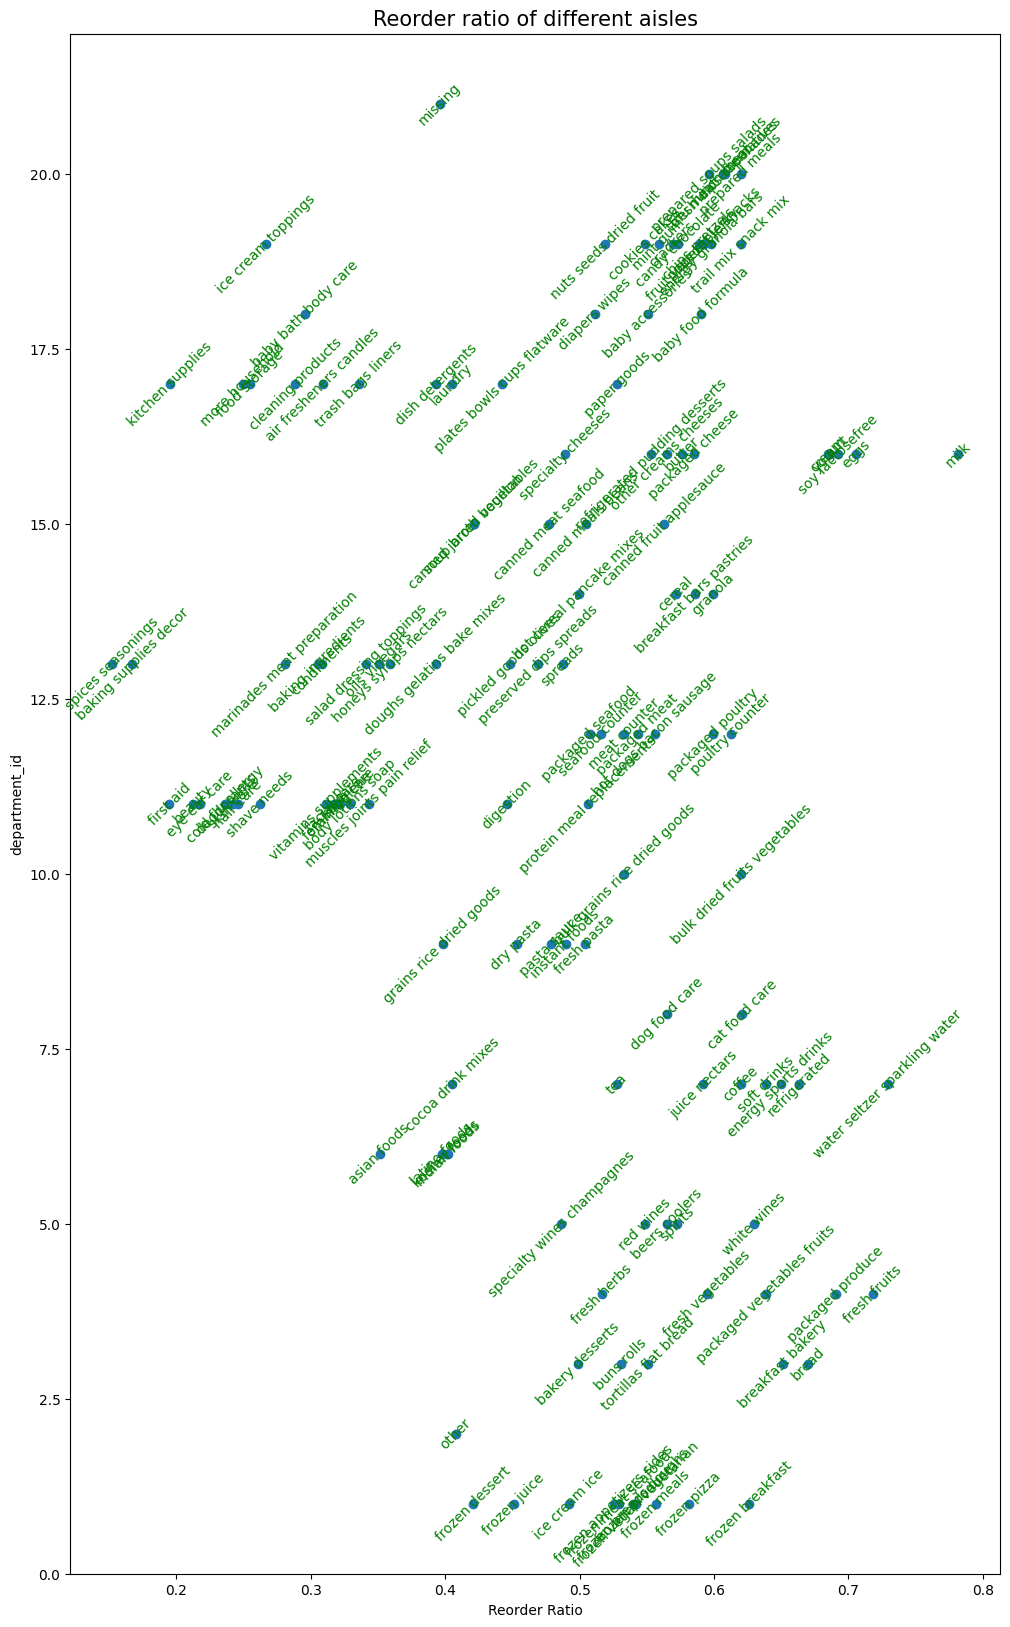

In [74]:
grouped_df = order_products_prior_df.groupby(['department_id', 'aisle'])['reordered'].aggregate('mean').reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title('Reorder ratio of different aisles', fontsize=15)
plt.show()

#### 🚩Add to Cart - Reorder ratio

##### 이제 제품을 장바구니에 추가한 순서가 재주문 비율에 어떻게 영향을 미치는지의 관계를 알아보자! 

/tmp/ipykernel_1783/3317685532.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  order_products_prior_df['add_to_cart_order_mod'].loc[order_products_prior_df['add_to_cart_order_mod']>70] = 70


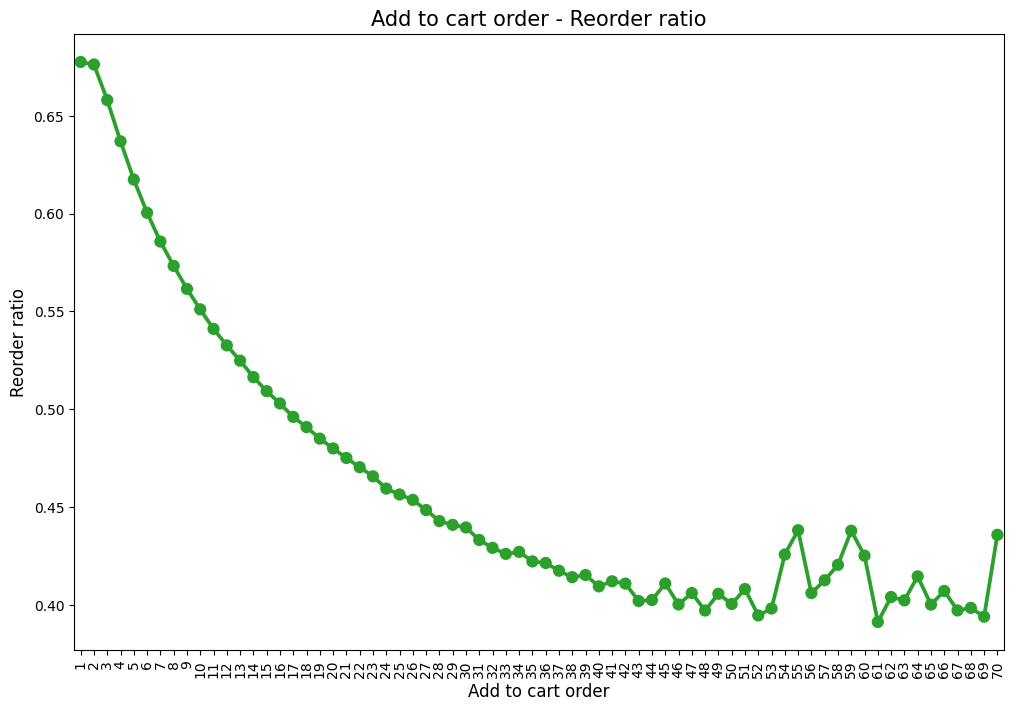

In [75]:
order_products_prior_df['add_to_cart_order_mod'] = order_products_prior_df['add_to_cart_order'].copy()
order_products_prior_df['add_to_cart_order_mod'].loc[order_products_prior_df['add_to_cart_order_mod']>70] = 70
grouped_df = order_products_prior_df.groupby(['add_to_cart_order_mod'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x= grouped_df['add_to_cart_order_mod'].values, y= grouped_df['reordered'].values, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title('Add to cart order - Reorder ratio', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

##### 처음에 장바구니에 추가된 제품들이 나중에 추가된 제품들에 비해 재주문될 가능성이 더 높아 보인다.  우리는 보통 자주 구매했던 제품들을 먼저 장바구니에 넣고, 그 후에 새로운 제품들을 찾아보기 때문일 것이다.

#### 🚩Reorder ratio by Time based variables

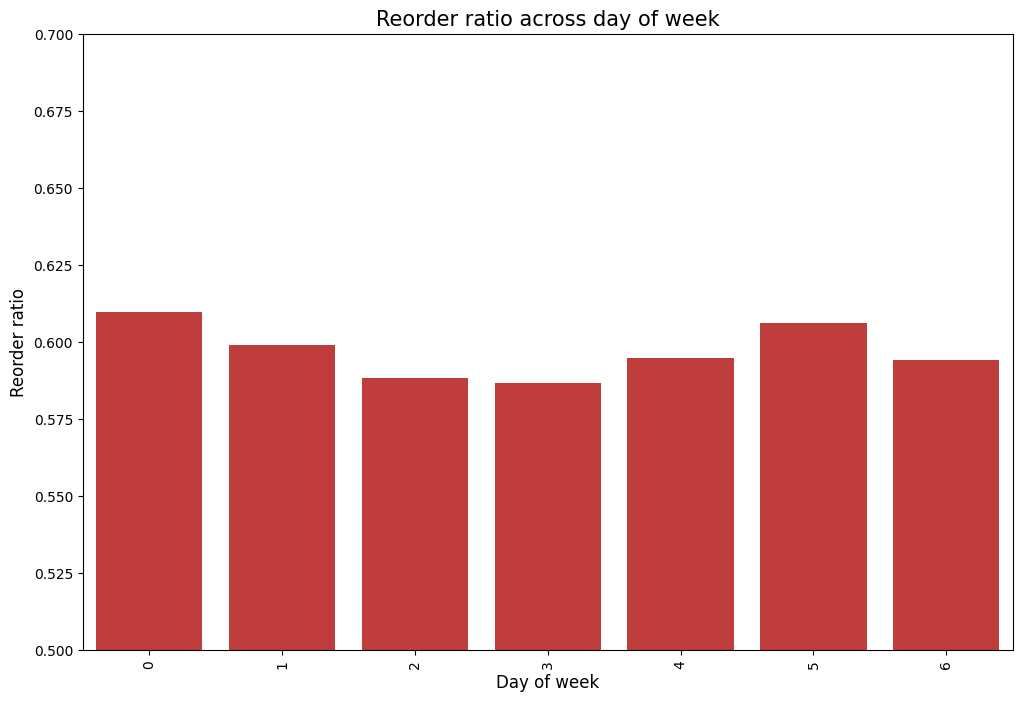

In [76]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left',suffixes=('_train', '_order'))
grouped_df = order_products_train_df.groupby(['order_dow'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_dow'].values, y=grouped_df['reordered'].values, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title('Reorder ratio across day of week', fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

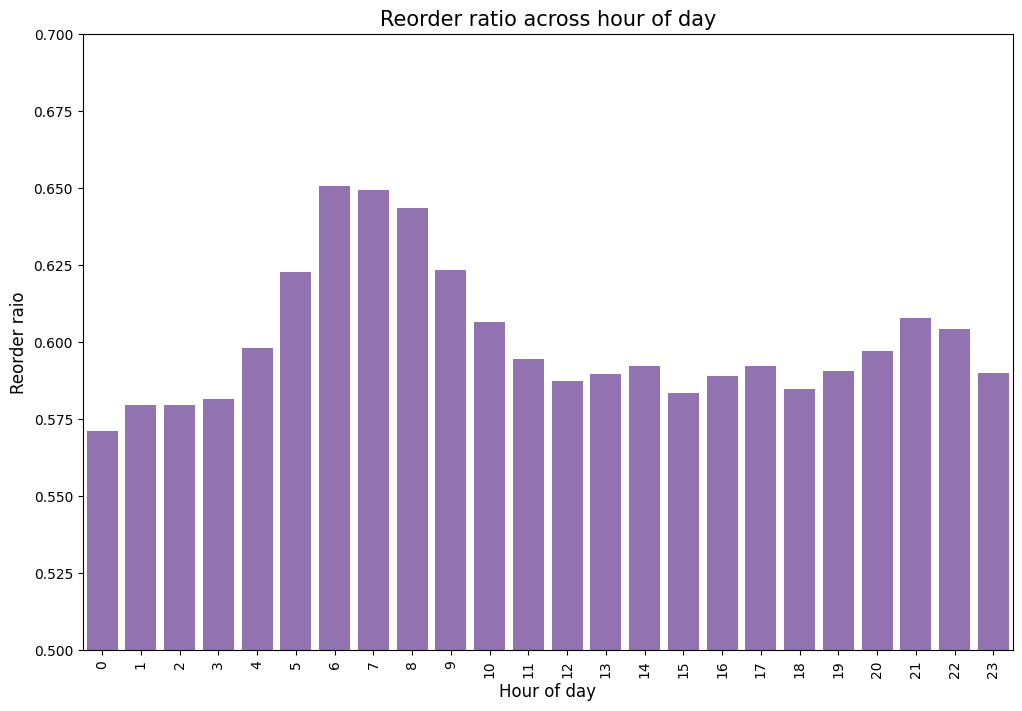

In [77]:
grouped_df = order_products_train_df.groupby(['order_hour_of_day'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_hour_of_day'].values, y=grouped_df['reordered'].values, color=color[4])
plt.ylabel('Reorder raio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title('Reorder ratio across hour of day', fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

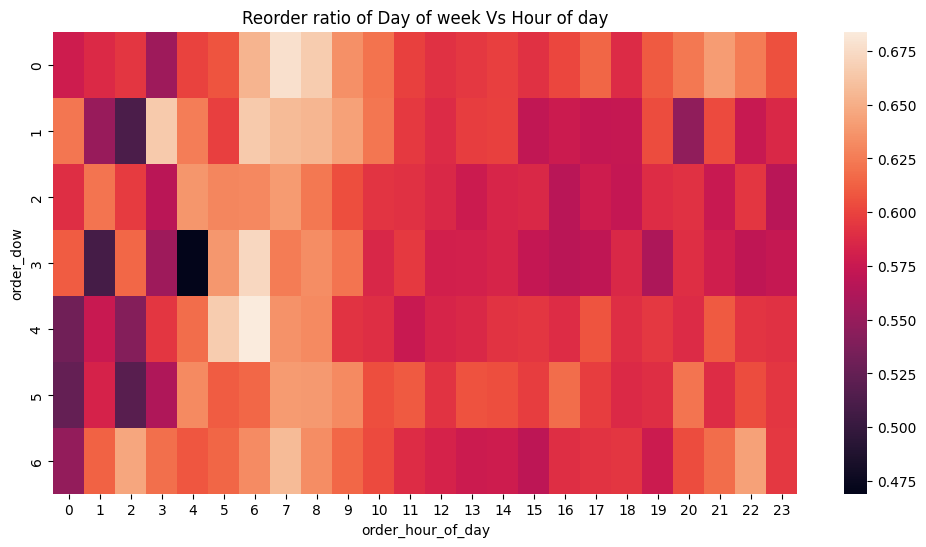

In [78]:
grouped_df = order_products_train_df.groupby(['order_dow','order_hour_of_day'])['reordered'].aggregate('mean').reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title('Reorder ratio of Day of week Vs Hour of day')
plt.show()

##### 재주문 비율이 하루 후반부에 비해 이른 아침에 높다는 것을 확인할 수 있다. 

#### 🧩새로운 전처리- department별로 가장 많이 주문된 시간대를 알아보자! 

In [79]:
products_df.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [7]:
order_products_prior_df = pd.merge(order_products_prior_df, orders_df, on='order_id', how='left')
order_products_prior_df.head(20)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0
5,2,17794,6,1,Carrots,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,doughs gelatins bake mixes,pantry,202279,prior,3,5,9,8.0
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry,202279,prior,3,5,9,8.0
8,2,43668,9,0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce,202279,prior,3,5,9,8.0
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs,205970,prior,16,5,17,12.0


##### department별로 가장 많이 주문된 시간대를 찾아야 하므로 mode를 이용한다. lambda x: x.mode()[0]를 사용하는 이유는 mode() 함수가 여러 개의 최빈값을 반환할 수 있기 때문에 각 그룹의 최빈값을 계산하여 첫 번째 최빈값을 반환하도록 하기 위해서이다.  

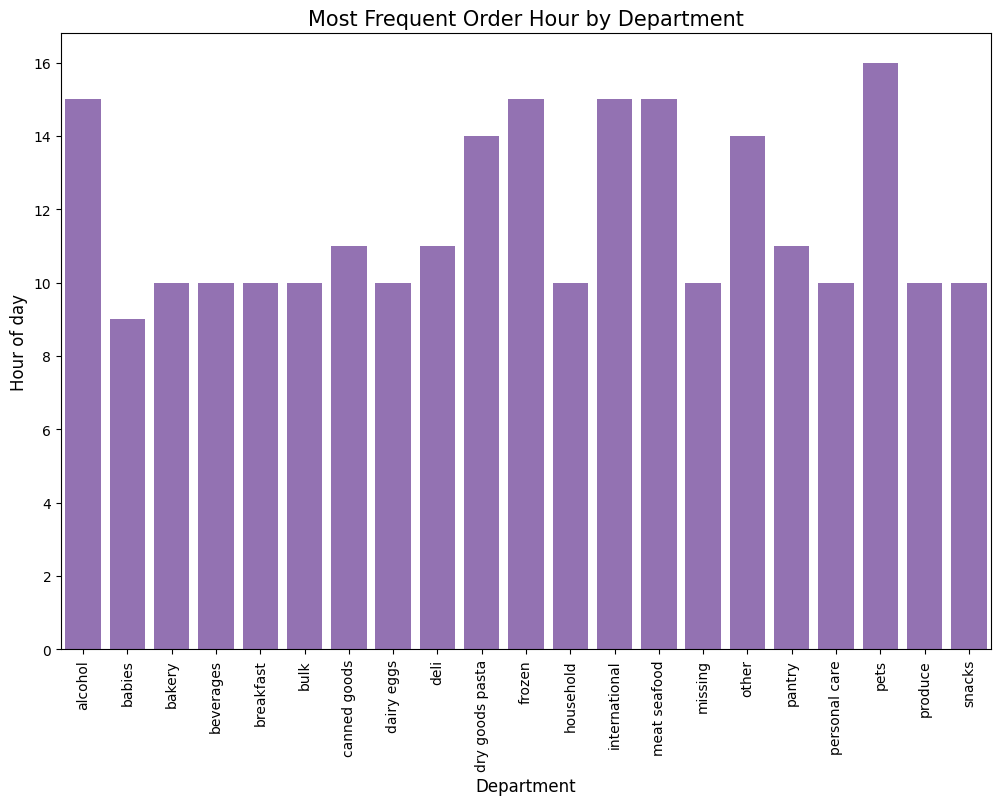

In [8]:
grouped_df = order_products_prior_df.groupby('department')['order_hour_of_day'].aggregate(lambda x: x.mode()[0]).reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['department'].values, y=grouped_df['order_hour_of_day'].values, color=color[4])
plt.ylabel('Hour of day', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title('Most Frequent Order Hour by Department', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

##### 아기용품(babies)이 가장 이른 시간대에 많이 주문되고, 애완동물용품(pets)이나 주류(alcohol)가 가장 늦은 시간대에 주문되는 경향성을 보인다.